## Comparing the performance of Gated Recurrent Units With and Without Attention
By learning to predict the text of H.G. Wells' The Time Machine

### Dataset

In [155]:
raw_lines = open('../datasets/timemachine.txt').readlines()


In [156]:
#for i, l in enumerate(raw_lines[3250:]):
#   print(i, l)
#lines[31:40]
# Remove the Project Gutenberg related lines from the beginning and end of the file
lines = raw_lines[31:3252]

### Let's tokenize the dataset


In [158]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

raw_text = '\n'.join(lines)
# Remove punctuation and convert to lowercase
text = raw_text.lower()
import re
text = re.sub(r'[^a-z]', ' ', text)
# Split the text into lines 
processed_lines = text.split('\n')

# Tokenize the text
tokenized_lines = [tokenizer.tokenize(line.lower()) for line in processed_lines]
# Clean the tokenized text
tokenized_lines = [tokens for tokens in tokenized_lines if len(tokens) > 0]
len(tokenized_lines)

/Users/vikram/dev/xjax/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (35766 > 512). Running this sequence through the model will result in indexing errors


1

In [159]:
# Count the number of tokens
num_tokens = sum([len(tokens) for tokens in tokenized_lines])
print(f"Number of tokens: {num_tokens}")
# Average number of tokens per line
avg_tokens = num_tokens / len(tokenized_lines)
print(f"Average number of tokens per line: {avg_tokens}")


Number of tokens: 35766
Average number of tokens per line: 35766.0


In [160]:
# Most common tokens
from collections import Counter
# Flatten the list of tokens
flat_tokens = [token for tokens in tokenized_lines for token in tokens]
# Count the tokens
token_counts = Counter(flat_tokens)
# Most common tokens
most_common_tokens = token_counts.most_common(10)
for token, count in most_common_tokens:
    print(f"{token} {count}")

the 2262
i 1274
and 1245
of 1155
a 835
to 700
in 599
was 552
that 443
my 441


[2262, 1274, 1245, 1155, 835, 700, 599, 552, 443, 441, 437, 354, 288, 271, 246, 222, 219, 204, 201, 186, 158, 156, 152, 137, 137, 137, 134, 133, 129, 127, 123, 122, 122, 120, 119, 117, 116, 115, 113, 113, 106, 105, 103, 100, 94, 94, 92, 91, 90, 89, 89, 89, 88, 86, 86, 85, 85, 85, 79, 77, 76, 75, 75, 75, 74, 74, 72, 72, 71, 70, 70, 69, 67, 66, 66, 64, 63, 62, 61, 60, 60, 57, 57, 57, 56, 56, 55, 54, 54, 51, 50, 50, 49, 49, 49, 49, 49, 49, 49, 48, 48, 48, 47, 47, 47, 47, 46, 46, 46, 45, 45, 44, 43, 43, 42, 42, 42, 41, 41, 40, 40, 40, 40, 39, 39, 39, 38, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 31, 31, 30, 30, 30, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20,

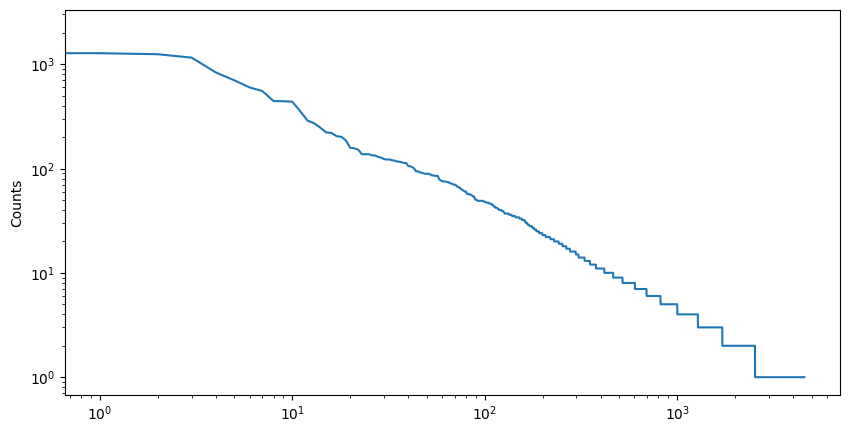

In [205]:
# Draw a graph of the token counts 
import matplotlib.pyplot as plt
# Get the tokens and counts
counts = [count for token, count in token_counts.items()]
# Sort the tokens and counts
sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
sorted_counts = sorted(counts, reverse=True)
print(sorted_counts)
# Plot the counts using a log scale
plt.figure(figsize=(10, 5))
plt.loglog(sorted_counts)
plt.ylabel('Counts')
plt.show()

In [62]:
### Generate the Vocabulary
tok_to_idx = {}
idx_to_tok = [] 

for line in tokenized_lines:
    for token in line:
        if token not in tok_to_idx:
            idx_to_tok.append(token)
            idx = len(tok_to_idx) - 1
            tok_to_idx[token] = idx

# Vocabulary size
vocab_size = len(idx_to_tok)
print(f"Vocabulary size: {vocab_size}")



Vocabulary size: 4904
